In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
import glob
from scipy.stats import poisson
from scipy.stats import multivariate_normal
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('../module/')
import abundance as cl_count
import covariance as covar
import edit
import lnlikelihood

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Binned data

In [15]:
for b in ['4x4', '20x30', '100x100']:
    dat = edit.load_pickle('/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/'+b+'_binned_catalogs.pkl')
    print(np.mean(dat[3][0]))

5919.25
157.84666666666666
9.4708


# Prediction

In [17]:
n_z_bin = 20
n_logm_bin = 30
z_corner = np.linspace(0.2, 1., n_z_bin + 1)
logm_corner = np.linspace(14.2, 15.6, n_logm_bin + 1)
Z_bin, logMass_bin = binning(z_corner), binning(logm_corner)

In [18]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi / 10
clc.f_sky = clc.sky_area/(4*np.pi)
print(clc.f_sky)
z_grid = np.linspace(0., 2.1, 2000)
logm_grid = np.linspace(14.1, 15.7, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

0.025


In [19]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

In [20]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin, NHalo_bias, Sij)/clc.f_sky

In [21]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

In [22]:
mu_list = Abundance.flatten()
#var_SSC_list = Sample_covariance.diagonal()
#MVP = mvp_pdf.MVP(mu_list, var_SSC_list)
#MVP._set_axis(5, mu_list, var_SSC_list)
#N_, P_MVP = MVP.p_mvp(mu_list, var_SSC_list)

# choose mu

In [39]:
index_list=np.arange(len(Abundance.flatten()))
index = index_list[(mu_list > 20)*(mu_list < 30)][0]
mu=Abundance.flatten()[index]
print(mu)
b = NHalo_bias.flatten()[index]/mu
Nb = NHalo_bias.flatten()[index]
S = Sample_covariance[index,index]/(Nb**2)

28.112105616906202


In [40]:
l = lnlikelihood.lnLikelihood()
MPG_ind = []
Nobs=np.arange(5, 50, )
res=[]
for n in Nobs:
    res.append(l.lnLikelihood_Binned_MPG_Block_Diagonal(mu, n, b, S, method = 'exact',single_variate=True))

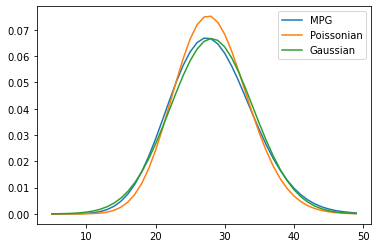

In [41]:
plt.plot(Nobs, np.exp(res)/np.sum(np.exp(res)), label='MPG')
plt.plot(Nobs, poisson(mu).pmf(Nobs), label='Poissonian')
plt.plot(Nobs, multivariate_normal.pdf(Nobs, mean=mu, cov=Sample_covariance[index,index] + mu), label='Gaussian')
plt.legend()

NameError: name 'N_' is not defined

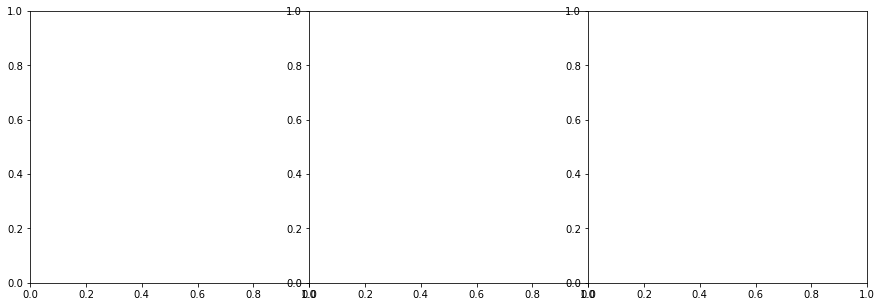

In [38]:
k = 0
intervals = [[1,2],[20,30],[200, 600]]
interval_done = [False, False, False]
bins = [np.arange(10)-.5, np.linspace(1,500,150), np.linspace(intervals[2][0],intervals[2][1],100)]
fig, ax = plt.subplots(1, 3, figsize = (15,5))
plt.subplots_adjust(wspace = 0)
plt.rcParams['axes.axisbelow'] = True
for n, p_mvp, i in zip(N_, P_MVP, np.arange(len(N_))):
    mu = mu_list[i]
    rv = poisson(mu)
    n_sigma = 4
    mask = (n > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(n < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
    poisson_ = rv.pmf(n)
    pdf = multivariate_normal.pdf(n, mean=mu, cov=var_SSC_list[i] + mu)
    for s, interval in enumerate(intervals):
        if (mu > interval[0])*(mu < interval[1])*(interval_done[s] == False):
            interval_done[s] = True
            ax[s].plot(n[mask], poisson_[mask], '-k', linewidth = 3, label = 'Poissonian')
            ax[s].plot(n[mask], pdf[mask]/np.sum(pdf), '-g', linewidth = 3, label = 'Gaussian')
            ax[s].plot(n[mask], p_mvp[mask], '--r', linewidth = 3, label = 'MVP')
            mask_bin = (bins[s] > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(bins[s] < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
            bins_corrected = bins[s][mask_bin]
            print(bins_corrected)
            ax[s].hist(N_new[:,i], density=True, bins = bins_corrected, histtype = 'step', linewidth = 3, alpha = 1)
            #a, b = np.histogram(N_new[:,i], bins = bins_corrected)
            #bin_middle = [(bins_corrected[i] + bins_corrected[i+1])/2 for i in range(len(bins_corrected)-1)]
            #a_normalized = a/(sum(a)*(bins_corrected[1]-bins_corrected[0]))
            #ax[s].plot(bin_middle, a_normalized, label = 'histogram')
            ax[s].set_xlabel(r'$n$', fontsize = 20)
            ax[s].tick_params(axis='both', which = 'major', labelsize= 15)
            if s == 0:
                ax[s].legend(frameon = False, framealpha = 1, fontsize = 16, loc = 'best')
            plt.setp( ax[s].get_yticklabels(), visible=False )
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/high_n.pdf', bbox_inches='tight', dpi=300)

In [13]:
#where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
#cat = glob.glob(where_cat)
#data_Fumagalli = []
#for i,c in enumerate(cat):
#    if i>1000: break
#    cat_test = pd.read_csv(c ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
#    ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.677
#    Ns, mass_edges, z_edges, im  = plt.hist2d(np.log10(Mvir),redshift, 
#                                       bins=[logm_corner,z_corner], cmin=0)
#    data_Fumagalli.append(Ns.T.flatten())